In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

### 데이터 불러오기

In [ ]:
df = pd.read_parquet("./data/ohlcv_full_BTCKRW.parquet") # 데이터 불러오기

In [ ]:
df

,ts,open,high,low,close,volume,time
0,1577836800000,8308000.0,8310000.0,8299000.0,8310000.0,2.466505,2020-01-01 09:00:00+09:00
1,1577836860000,8300000.0,8300000.0,8300000.0,8300000.0,2.589775,2020-01-01 09:01:00+09:00
2,1577836920000,8299000.0,8300000.0,8299000.0,8300000.0,1.397383,2020-01-01 09:02:00+09:00
3,1577836980000,8300000.0,8300000.0,8299000.0,8300000.0,1.373265,2020-01-01 09:03:00+09:00
4,1577837040000,8299000.0,8299000.0,8296000.0,8296000.0,2.319195,2020-01-01 09:04:00+09:00
...,...,...,...,...,...,...,...
3052384,1761886740000,165147000.0,165149000.0,165068000.0,165125000.0,0.353609,2025-10-31 13:59:00+09:00
3052385,1761886800000,165072000.0,165125000.0,164910000.0,165001000.0,1.075655,2025-10-31 14:00:00+09:00
3052386,1761886860000,165004000.0,165004000.0,164812000.0,164814000.0,1.402556,2025-10-31 14:01:00+09:00
3052387,1761886920000,164814000.0,164873000.0,164769000.0,164843000.0,1.615205,2025-10-31 14:02:00+09:00


### 트레이딩 전략의 종류

아래의 내용보다 더 다양하게 있겠지만, 내가 관심이 있고 써볼만한 전략들은 아래 3가지가 있을 듯 하다.

- "추세" 추종 전략 : 캔들의 고점, 저점, 이동평균 등을 이용하여 방향성을 따라 매매하는 전략. (시장에 맞서지 말라!)
- "평균회귀" 전략(역추세 반전 전략) : 일정 기간 과매수/과매도 상태나 급등락 후 반전 시그널을 이용하는 전략. 추세추종전략과 상관관계가 (-)일 것으로 예상.
- 변동성 "돌파" 전략 : 박스권을 유지하던 가격이 좁은 캔들구간을 벗어나서 크게 상승하는 경우.

### 트레이딩 전략의 기본 구성

트레이딩 전략은 기본적으로 아래 세가지로 구성된다고 보면 될듯하다.

1. 시그널 탐지 (Signal Detection) : 진입을 고려할 수 있는 조건을 찾는 단계
2. 진입 로직 (Entry Logic) : 실제로 포지션을 진입할지 결정
3. 청산 로직 (Exit Logic) : 언제 포지션을 그만둘지

### 트레이딩 전략의 python 소스코드 실제 구현

1. 데이터 전처리
2. 전략 구현[시그널탐지 - 진입가격 - 청산가격(익절가, 손절가,최대기간)]
3. 전략별 데이터타입을 어떻게해서 관리하지? (전략의 추가/제거를 쉽게 할 수 있도록)
- 가격 : 시간(row) x OHLCV(columns)
- 시그널 : 시간(row) x 전략들(columns). 시그널 탐지시 True
- 진입가격 : 시간(row) x 전략들(columns). 시그널 탐지 안됬으면 False, 됬으면 가격
- 보유포지션 : 시간(row) x 전략들(columns). 진입 안했으면 0, 진입 했으면 규모
- 익절가격 : 시간(row) x 전략들(columns). 시그널 탐지 안됬으면 False, 됬으면 가격
- 손절가격 : 시간(row) x 전략들(columns). 시그널 탐지 안됬으면 False, 됬으면 가격
- 보유기간(일정수준 이상 넘기면 청산하기 위함) : 시간(row) x 전략들(columns). 시그널 탐지 안됬으면 False, 됬으면 가격

결국 핵심은 시그널(조건), 진입가격, 보유포지션, 익절가격, 손절가격, 보유기간을 산출하는 "전략"을 수립하는 함수를 짜는 것.

##### 1. 데이터 전처리

In [2]:
def preprocess_ohlcv(
    df: pd.DataFrame,
    tz: str = "Asia/Seoul",
    freq: str = "1D",
    fill_method: str = "ffill"
) -> pd.DataFrame:
    """
    OHLCV 데이터 전처리 함수 (백테스팅 전용)

    Parameters
    ----------
    df : pd.DataFrame
        최소한 ['open', 'high', 'low', 'close'] 열을 포함해야 함.
        DatetimeIndex 또는 'timestamp' 컬럼 필요.
    tz : str
        타임존 지정 (기본: Asia/Seoul)
    freq : str
        리샘플 주기 (예: '1D', '1H', '5T')
    fill_method : str
        결측치 보정 방식 ('ffill', 'bfill', None)

    Returns
    -------
    pd.DataFrame
        전처리된 OHLCV 데이터프레임
    """

    # ---- 1. 인덱스 설정 ----
    df = df.set_index("time")

    # ---- 2. 중복 제거 및 정렬 ----
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # ---- 4. 리샘플링 ----
    df = df.resample(freq).agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum" if "volume" in df.columns else "first"
    })

    # ---- 5. 결측치 처리 ----
    if fill_method == "ffill":
        df = df.ffill()
    elif fill_method == "bfill":
        df = df.bfill()

    # ---- 6. 이상치 제거 ----
    for col in ["open", "high", "low", "close"]:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=["open", "high", "low", "close"])

    # ---- 7. 보조 컬럼 추가 ----
    df["returns"] = df["close"].pct_change()
    df["log_ret"] = np.log(df["close"] / df["close"].shift(1))

    return df

In [3]:
df = pd.read_parquet("./data/ohlcv_full_BTCKRW.parquet") # 데이터 불러오기
df = preprocess_ohlcv(df, tz="Asia/Seoul", freq="1T")

C:\Users\MP_Doctor\AppData\Local\Temp\ipykernel_67616\550200241.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample(freq).agg({


In [4]:
df

,open,high,low,close,volume,returns,log_ret
time,,,,,,,
2020-01-01 09:00:00+09:00,8308000.0,8310000.0,8299000.0,8310000.0,2.466505,NaN,NaN
2020-01-01 09:01:00+09:00,8300000.0,8300000.0,8300000.0,8300000.0,2.589775,-0.001203,-0.001204
2020-01-01 09:02:00+09:00,8299000.0,8300000.0,8299000.0,8300000.0,1.397383,0.000000,0.000000
2020-01-01 09:03:00+09:00,8300000.0,8300000.0,8299000.0,8300000.0,1.373265,0.000000,0.000000
2020-01-01 09:04:00+09:00,8299000.0,8299000.0,8296000.0,8296000.0,2.319195,-0.000482,-0.000482
...,...,...,...,...,...,...,...
2025-10-31 13:59:00+09:00,165147000.0,165149000.0,165068000.0,165125000.0,0.353609,-0.000145,-0.000145
2025-10-31 14:00:00+09:00,165072000.0,165125000.0,164910000.0,165001000.0,1.075655,-0.000751,-0.000751
2025-10-31 14:01:00+09:00,165004000.0,165004000.0,164812000.0,164814000.0,1.402556,-0.001133,-0.001134


단기적/중기적/장기적 고점 및 저점을 정의해야 이를 바탕으로 단기적/중기적/장기적 상승 및 하락추세를 정의할 수 있음.

분봉 -> 단기적 고/저점 -> 중기적 고/저점 -> 장기적 고/저점 순서로 구해야 함.

단기적 고/저점은 분봉을 통해, 중기는 단기를 통해, 장기는 중기를 통해 구하는 것임.

단기적 고/저점은 분봉 고점 양쪽에 이보다 낮은 분봉 고점이 존재할 때 정의될 수 있음. ^자 모양이라고 생각하면 될듯. 하지만, 문제는 해당 지점에서 그게 단기적 고점이라고 확정할 수 없다는 것임. 단기적 고점 그 이후 이보다 낮은 고가(High)가 찍혀야 단기적 고점이라고 확인할 수 있음. 위 내용은 중기적, 장기적 고/저점을 판단할 때에도 똑같이 적용되는 바임.

따라서, 단기 투자 전략에서는 단기 고점이 확정될 때를 매수포지션의 청산지점으로 정의할 수 있을 것. 이는 중기/장기에서도 마찬가지.

그렇다면 진입시점은 어떻게 정의할 수 있을까?

추세추종전략은 추세를 확인하고 들어가야 함. 반면, 평균회귀 전략에서는 추세가 사라졌음을 확인하면 진입해야 함.

추세를 확인하거나, 추세가 사라졌음을 확인하는 프로세스는 복잡하고 여러가지 방법이 있을 수 있음. 일단, 단기/중기/장기적 고/저점을 정의해보도록 하자.

구현하려고 하니, 단기/중기/장기 저점 및 고점을 구하는 로직도 상당히 복잡하군. 이건 취지에 맞지 않아. 일단 간단하게 짜보도록 하자.

##### 2. 전략 구현

추세추종 전략

1. 시그널 탐지
- 상승 추세 탐지 : 현재 가격이 MA(5), MA(20) 보다 높음
- 상승 추세의 강도 판단 : 이격도. MA(5) - MA(20) 수치로 판단. 이 수치가 높을수록 상승강도가 거센 것.
- 상승 추세의 지속성 판단 : 변동성을 감안했을 때 안정적 상승인지 판단. ((MA20 대비 MA5가 높은 정도%)/MA20변동성)

In [5]:
close = df["close"]

In [6]:
up_detected = (close > close.rolling(5).mean()) & (close > close.rolling(20).mean()) # 상승 추세 탐지
up_strength = close.rolling(5).mean() - close.rolling(20).mean()# 상승 추세 강도
up_persistence = (close.rolling(5).mean()-close.rolling(20).mean())/close.rolling(20).mean() / close.rolling(20).std()# 상승 추세 지속성

In [7]:
cutoff_strength = up_strength[up_detected].quantile(0.75)
cutoff_persistence = up_persistence[up_detected].quantile(0.75)

In [8]:
investible = up_detected & (up_strength > cutoff_strength) & (up_persistence > cutoff_persistence)
investible = investible.shift()

In [9]:
# 만약 결측치가 있던 상황이라면, 그 투자건은 사용하지 않겠음. 어떻게 구현하지?
for i in range(20, len(investible)):
    if investible.iloc[i] == True:
        if (investible.index[i] - investible.index[i-20]).total_seconds()/60 == 20: # 20행 시간차가 2분이 맞으면
            continue # 넘어가고
        else: # 아니면
            investible.iloc[i] = False # 시그널 취소

In [10]:
investible.sum()

53637

##### 2. 전략 실현. (진입가격, 손절가격, 익절가격, 최대보유기간 정의)

- 초기자금 : 10억
- 1회 투자자금 : 보유자금의 5% (초기 5천만원)
- 진입가격 : 매수 시그널 나온 후의 시가
- 손절가격 : MA(5)
- 익절가격 : +5%에서 익절. 하지만, 매수강도가 진입때보다 높다면 절반만 익절.
- 최대보유기간 : 2시간(120행)

In [32]:
result = pd.DataFrame(columns = ["account", "entry_time", "exit_time", "entry_price", "exit_price", "entry_amount", "exit_amount", "PnL", "ret", "result"]) # 결과 정리 표

In [33]:
# 초기 설정
account = 1000000000 # 현재 내 자금
amount = account * 0.05 # 1회 투자자금
status = False # 현재 투자하고 있는가?
maximum_holding_period = 120 # 최대보유기간 : 2시간(120행)

entry_time = np.nan # 진입시점
exit_time = np.nan # 청산시점
entry_price = np.nan # 진입가
PnL = 0


In [34]:
for i in range(len(investible)-1):
    t = df.index[i] # 시간 
    _investible = investible.loc[t] # 시그널 탐지 여부
    
    if t.day == 1 and t.hour == 0 and t.minute == 0:
        print(t)

    if _investible == True: # 시그널 탐지한 경우
        if status == True: # 이미 투자하고 있다면,
            pass
        else: # 투자하고 있지 않다면
            status = True # 투자를 할 것임.
            entry_time = t
            entry_price = df.loc[t, 'open']
            entry_amount = amount
            _len = len(result)
            result.loc[_len, "entry_time"] = entry_time # 진입시간 입력
            result.loc[_len, "entry_price"] = entry_price # 진입가격 입력
            result.loc[_len, "entry_amount"] = entry_amount # 진입가격 입력
            result.loc[_len, "PnL"] = 0 # 손익은 0
            _strength = (df.loc[:t, 'close'].rolling(5).mean() - df.loc[:t, 'close'].rolling(20).mean()).loc[t]

    if len(result) == 0:
        continue

    _close = df.loc[t, 'close']
    _stop_loss = _close < df.loc[:t, 'close'].rolling(20).mean().loc[t] # 손절여부
    _take_profit = _close/entry_price - 1 > 0.05 # 익절여부(5% 이상 수익 발생)
    _time_over = (t - result.loc[len(result) - 1, "entry_time"]).total_seconds()/60 > maximum_holding_period # 시간초과

    if status == True:
        weaken = (df.loc[:t, 'close'].rolling(5).mean() - df.loc[:t, 'close'].rolling(20).mean()).loc[t] < _strength # 강도가 진입시점에 대비해서 약해졌는지 여부
        if _stop_loss == True or (_take_profit == True and weaken == True) or _time_over == True: # 청산해야한다면..
            _len = len(result) - 1
            ret = _close/entry_price - 1 # 수익률
            PnL = ret * entry_amount # 손익규모
            
            ### 투자 결과 값 입력
            result.loc[_len, "exit_time"] = t
            result.loc[_len, "exit_price"] = _close
            result.loc[_len, "PnL"] = result.loc[_len, "PnL"] + PnL
            result.loc[_len, "exit_amount"] = result.loc[_len, "entry_amount"] + result.loc[_len, "PnL"]
            result.loc[_len, "ret"] = result.loc[_len, "PnL"]/result.loc[_len, "entry_amount"]
            result.loc[_len, "account"] = account + result.loc[_len, "PnL"]
            
            # 투자 결과가 익절인지, 손절인지, 시간초과인지 입력
            if _stop_loss == True:
                result.loc[_len, "result"] = "lose"
            elif _take_profit == True:
                result.loc[_len, "result"] = "win"
            elif _time_over == True:
                result.loc[_len, "result"] = "time over"    
            
            # 투자가 끝난 후 값 정리.
            status = False # 투자를 하지 않은 상태로 변경
            account = account + result.loc[_len, "PnL"] # 현재 자금 재정의
            amount = account * 0.05 # 투자자금 재정의
            PnL = 0
        
        # 만약 상승 강도가 과거와 같거나 더 강하다면, 반만 익절하고 투자는 계속 진행.
        elif _take_profit == True and weaken == False:
            _len = len(result) - 1
            ret = _close/entry_price - 1 # 수익률
            PnL = ret * entry_amount * 0.5 # 손익규모 (반만 익절)
            
            ### 여기서는 PnL을 절반만 취하고, 나머지 절반은 투자 재개
            result.loc[_len, "PnL"] = result.loc[_len, "PnL"] + PnL
            entry_amount = entry_amount / 2 

2020-02-01 00:00:00+09:00
2020-03-01 00:00:00+09:00
2020-04-01 00:00:00+09:00
2020-05-01 00:00:00+09:00
2020-06-01 00:00:00+09:00
2020-07-01 00:00:00+09:00
2020-08-01 00:00:00+09:00


KeyboardInterrupt: 

<Axes: >

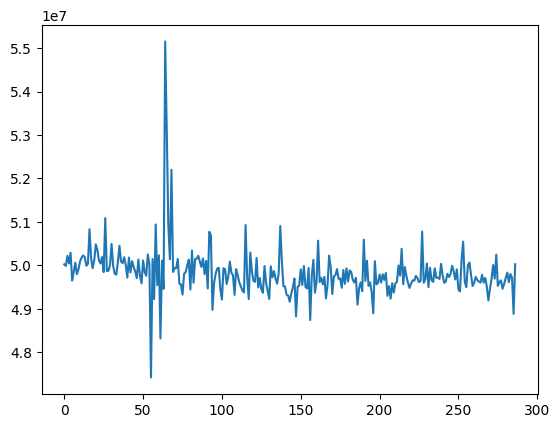

In [44]:
result["exit_amount"].plot()